In [146]:
using PyPlot
using DataFrames
using CSV
import Statistics

In [147]:
include("./src/loop_function.jl")
include("./src/tmat.jl")
include("./src/tmat_up_to_nlo.jl")
include("./src/par.jl")
include("./src/subtraction_cons.jl")

subtraction_cons_tuple (generic function with 1 method)

In [148]:
import PyCall
iminuit = PyCall.pyimport("iminuit");

In [149]:
par = phy_par_degenrate()

Dict{Symbol, Any} with 4 entries:
  :threshold  => [1331.19, 1434.58, 1663.19, 1813.71]
  :mch        => [(138.039, 1193.15), (495.665, 938.919), (547.51, 1115.68), (4…
  :meson_mass => (138.039, 495.665)
  :decons     => 100.69

In [150]:
b = (-0.664609603537589, 0.062434962905761365, -0.35384103271852047)
d = (-0.46011427499158786, 0.05501054906425522, -0.06775661407295062, -0.5884345325719142);

In [151]:
D = Dmat(par, b)
L = Lmat(d)

4×4 Matrix{Float64}:
 -0.00166794   -0.00033018    0.000117358  -0.000796866
 -0.00033018   -0.00160746   -0.000537867   0.000533333
  0.000117358  -0.000537867  -0.00131238   -0.000112833
 -0.000796866   0.000533333  -0.000112833  -0.000687236

In [152]:
w = range(1370., 1480., 250)
vnlo11 = [real(vnlo_swave(ww, par, D, L, n=4)[1, 1] ) for ww in w]
vnlo14 = [real(vnlo_swave(ww, par, D, L, n=4)[1, 2] ) for ww in w]

vlo11 = [real(WT(ww, par, C_mat(), n=4)[2, 2]) for ww in w]
vlo14 = [real(WT(ww, par, C_mat(), n=4)[1 ,2]) for ww in w];

In [153]:
D, F = 0.8, 0.46;

In [154]:
function VC(w, par, (mi, Mi), (mj, Mj), Mk)
    s = w*w
    f = par[:decons]
    Ni = norm_factor(w, (mi, Mi) )
    Nj = norm_factor(w, (mj, Mj) )
    Ei = baryon_energy(w, (mi, Mi) )
    Ej = baryon_energy(w, (mj, Mj) )
    qi = qcm(w, mi, Mi)
    qj = qcm(w, mj, Mj)
    v = Ni * Nj * (w + Mk - (Mi + Mk) * (Mj + Mk) / (2e0(Mi + Ei)*(Ej + Mj)) * (w - Mk + Mi + Mj) +
    (Mi + Mk)*(Mj + Mk)/(4e0*abs(qi)*abs(qj)) * (w + Mk - Mi - Mj - (s + Mk^2 - mi^2 -mj^2 -2e0Ei*Ej) / (2e0 *(Mi + Ei) * (Mj + Ej)) * (w - Mk + Mi + Mj) ) *
    # (-2) * (s - mi^2 - mj^2 -Mk^2) / abs(s - mi^2 -mj^2 -Mk^2)* atan(abs(2abs(qi*qj)/(s-mi^2-mj^2-Mk^2)))
    log((s + Mk^2 - mi^2 -mj^2 -2e0Ei*Ej - 2e0*abs(qi)*abs(qj)) / (s + Mk^2 - mi^2 - mj^2 -2e0Ei*Ej + 2e0abs(qi)*abs(qj)) )
    )
    return v * (-1/(2f^2))
end



function VC14(w, par, (mi, Mi), (mj, Mj), Mk1, Mk2)
    # CΛ = -D - 3e0F
    CΣ1 = -sqrt(3/2) * (D^2 - F^2)
    # CΣ2 = -sqrt(3.) * (D - F)
    return CΣ1 * VC(w, par, (mi, Mi), (mj, Mj), Mk2)
end

VC14 (generic function with 1 method)

In [155]:
function VD(w, par, (mi, Mi), (mj, Mj), Mk)
    s = w*w
    f = par[:decons]
    Ni = norm_factor(w, (mi, Mi) )
    Nj = norm_factor(w, (mj, Mj) )
    return 1. / (2e0f^2) * Ni * Nj * (w - Mi)*(w-Mk)*(w-Mj) / (s - Mk^2)
end

function VD11(w, par, (mi, Mi), Mk1, Mk2)
    
    CΣ = (D +3F)^2 / 3.
    return CΣ * VD(w, par, (mi, Mi), (mi, Mi), Mk2)
end
function VD14(w, par, (mi, Mi), (mj, Mj), Mk1, Mk2)

    CΣ1 = sqrt(2/3) * D * (D+3F)
    # CΣ2 = -sqrt(3. / 2.) * (D^2 - F^2)
    return CΣ1 * VD(w, par, (mi, Mi), (mj, Mj), Mk2)
end

mLam = 1115.
mpi = 139.039
mN = 938.
mKbar=495.
mSig = 1193.15

1193.15

In [156]:
vd11 = [real(VD11(ww, par, (mKbar, mN), mLam, mLam)) for ww in w]
vd14 = [real(VD14(ww, par, (mKbar, mN), (mpi, mSig), mLam, mLam)) for ww in w];

# vc11 = [real(VC11(ww, par, (mKbar, mN), mN, mN)) for ww in w]
vc14 = [real(VC14(ww, par, (mKbar, mN), (mpi, mSig), mN, mN)) for ww in w];

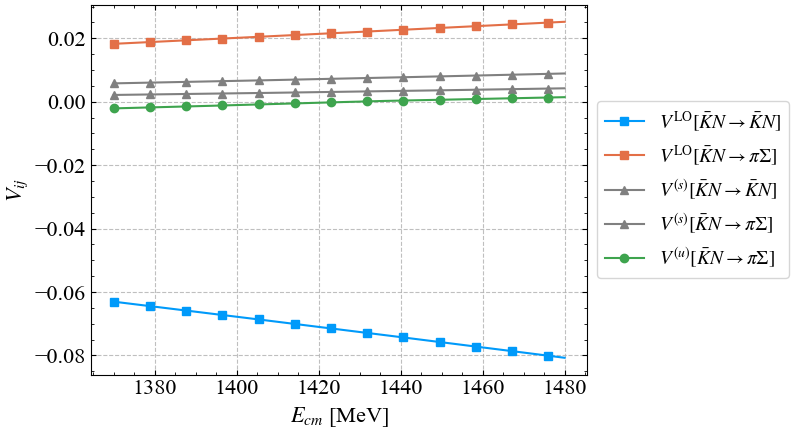

In [157]:

fig, ax = PyPlot.subplots()

ax.plot(w, (vlo11), marker="s", markevery = 20, label=L"V^{\mathrm{LO}}[\bar{K}N \to \bar{K}N]")
ax.plot(w, (vlo14), marker="s", markevery = 20, label=L"V^{\mathrm{LO}}[\bar{K}N \to \pi\Sigma]")

# ax.plot(w, vnlo11, marker="o", markevery = 20, label=L"V^{\mathrm{NLO}}[K^- p \to K^- p]")
# ax.plot(w, vnlo14, marker="o", markevery = 20, label=L"V^{\mathrm{NLO}}[K^- p \to \bar{K}^0 n]")



ax.plot(w, vd11, marker="^", markevery = 20, label=L"V^{(s)}[\bar{K}N \to \bar{K}N]", c=:gray)
ax.plot(w, vd14, marker="^", markevery = 20, label=L"V^{(s)}[\bar{K}N \to \pi\Sigma]", c=:gray)
ax.plot(w, vc14, marker="o", markevery = 20, label=L"V^{(u)}[\bar{K}N \to \pi\Sigma]")

# ax.plot(w, vc11, label=L"V^\mathrm{C}[K^- p \to K^- p]")
# ax.plot(w, vc14, label=L"V^\mathrm{C}[K^- p \to \bar{K}^0 n]")

ax.legend(loc = "center left", bbox_to_anchor=(1, 0.5))
ax.set(xlabel=L"$E_{cm}$ [MeV]", ylabel=L"V_{ij}")
ax.grid()
fig.savefig("./figure/potential_conr.pdf")
fig